<a href="https://colab.research.google.com/github/oliva0620/23bigdata_exam/blob/cs/%5BML_04%5D_regression_Teacher.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 0.회귀 분석의 종류

In [ ]:
target(Y)
분류 분석 : 범주형, 혈액형(A, B, O, AB), 성별(F, M), 숫자(0, 1, ~ 9)
회귀 분석 : 연속형, 판매량(0, 1, 2, 3, ... 100, 101, 102..)
   주어진 값보다 더 큰값, 작은값, 사잇값 등이 있을 수 있는 것

### Simple Linear Regression
- 단순 선형 회귀
- $y = \beta_{0} + \beta_{1} x + \epsilon$
- 하나의 X 값을 가지고 Y를 예측하는 것

### Multiple Linear Regression
- 다중 회귀
- $y = \beta_{0} + \beta_{1} x_{1} + \beta_{2} x_{2} + ...+ \epsilon$
- 여러 개의 X 값을 가지고 Y를 예측하는 것

### Polynomial Regression
- 다항 회귀
- 비선형 데이터 집합을 모델링 할 때 사용
- 곡선의 다항식 선을 사용함
- 과대적합이 나타나기 쉬움
- $y = \beta_{0} + \beta_{1} x_{1} + \beta_{2} x_{2} + \beta_{3} x_{1}^{2} + \beta_{4} x_{2}^{2} ...+ \epsilon$
- X를 다항식으로 변경하여 모델링의 데이터로 사용함

### Ridge, Lasso Regression
- 독립변수들 간에 높은 상관 관계가 있는 경우 규제화 (regularization)를 적용해 모델의 복잡도를 줄임
- Ridge : 계수값을 0 에 가깝게 만들지만 0 이 되지 않음
- Lasso : 계수 값을 0으로 만들 수 있음

## 1.데이터 만들기 

### 1-1.함수 만들기

In [ ]:
# X : 키, 몸무게 
# Y : BMI 예측

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
# https://rfriend.tistory.com/284
# https://rfriend.tistory.com/352
# https://namu.wiki/w/%ED%82%A4(%EC%8B%A0%EC%B2%B4)
# https://123dok.co/document/eqodvrmz-%EC%A7%80%EC%97%AD%EC%A0%81-%EA%B1%B4%EA%B0%95%EB%B6%88%ED%8F%89%EB%93%B1%EA%B3%BC-%EA%B0%9C%EC%9D%B8-%EB%B0%8F-%EC%A7%80%EC%97%AD%EC%88%98%EC%A4%80%EC%9D%98-%EA%B1%B4%EA%B0%95%EA%B2%B0%EC%A0%95%EC%9A%94%EC%9D%B8.html

In [ ]:
# bmi = 몸무게(kg) ÷ (신장(m) × 신장(m))
# 한국 표준 데이터 생성
# seedno : 랜덤 수 발생 관련
# size : sample의 개수
# startno : ID의 시작 번호
# outlier : 이상치 비율, 0.01 => 100개 정상데이터 1개 이상치
def make_sample(seedno, size, startno=0, outlier=0):
    np.random.seed(seedno)
    outlier_len = int(size*outlier)
    sizeh = size//2
    # 키의 단위 cm
    hm = np.random.normal(loc=175, scale=5.3, size = sizeh+1 if size % 2 else sizeh).round(1)
    hw = np.random.normal(loc=162, scale=5.2, size = sizeh).round(1)
    h = np.concatenate([hm, hw])
    h /= 100   # 단위를 m로 변경
    bmi = np.random.normal(loc=23, scale=4, size=len(h))
    w = (h*h*bmi).round(1)
    bmi = (w / (h*h)).round(2)
    h *= 100   # 단위를 cm로 변경
    data = np.column_stack([h, w, bmi])

    # 이상치 데이터 추가
    if outlier_len != 0:
        data_outlier = make_outlier(seedno, outlier_len)
        print(data_outlier, data_outlier.shape, sep='\n')
        data = np.concatenate([data, data_outlier])

    # 'ID'를 포함한 DataFrame 생성 및 반환
    data = pd.DataFrame(data, columns=['height', 'weight', 'BMI'])
    data = data.sample(frac=1)
    data.insert(0, 'ID', np.arange(startno, startno + len(data), dtype='int'))
    return data



In [ ]:
# bmi = #몸무게(kg) ÷ (신장(m) × 신장(m))
# 키, 몸무게가 매우 작거나 큰 데이터 생성
# seedno : 랜덤 수 발생 관련
# size : sample의 개수
def make_outlier(seedno, size):
    np.random.seed(seedno)
    sizeh = size//2
    hlow = np.random.normal(loc=120, scale=5.3, size=sizeh+1 if size % 2 else sizeh).round(1)
    hhigh = np.random.normal(loc=220, scale=5.2, size=sizeh).round(1)
    h = np.concatenate([hlow, hhigh])
    h /= 100
    bmi = np.random.normal(loc=23, scale=10, size=len(h))
    w = (h*h*bmi).round(1)
    bmi = (w / (h*h)).round(2)
    h *= 100
    return np.column_stack([h, w, bmi])

In [ ]:
# make_sample 사용연습
df = make_sample(1234, 100, outlier=0.05)
df.shape
#df.describe()

[[122.5   47.8   31.85]
 [113.7   40.8   31.56]
 [127.6   27.1   16.64]
 [218.4  110.5   23.17]
 [216.3    2.7    0.58]]
(5, 3)


(105, 4)

### 1-2.train, test 데이터

In [ ]:
# [1] train, test 데이터 생성 및 파일로 저장하기
train = make_sample(1234, 100)
test = make_sample(1, 100, len(train))
Xfeatures = ['ID', 'height', 'weight']
Yfeatures = ['ID', 'BMI']
Xtrain = train[Xfeatures]
Ytrain = train[Yfeatures]
Xtest = test[Xfeatures]
Ytest = test[Yfeatures]  # 실제 시험에서는 주지 않음!
Xtrain.to_csv('x_train.csv', index=False)
Ytrain.to_csv('y_train.csv', index=False)
Xtest.to_csv('x_test.csv', index=False)
Ytest.to_csv('y_test.csv', index=False)  # 실제 시험에서는 주지 않음!

In [ ]:
# [2] 각 데이터를 파일에서 읽어오기
# X_use, X_submission, Y, Y_hidden 이름 사용
X_use = pd.read_csv('x_train.csv')
X_submission = pd.read_csv('x_test.csv')
Y = pd.read_csv('y_train.csv')
Y_hidden = pd.read_csv('y_test.csv')

In [ ]:
# X_use, Y를 합쳐서 dfXY 생성
dfXY = pd.merge(X_use, Y)
dfXY.shape

(100, 4)

In [ ]:
# dfXY의 상관 관계 확인
dfXY.corr()

,ID,height,weight,BMI
ID,1.000000,0.140693,-0.022971,-0.108252
height,0.140693,1.000000,0.604015,0.178859
weight,-0.022971,0.604015,1.000000,0.887726
BMI,-0.108252,0.178859,0.887726,1.000000


## 2.모델링, 성능평가

### 2-1.모델링 함수

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [ ]:
# [1] 데이터를 분리하고, 학습 한 뒤, R2_score를 구해 출력
def Model_Train(model, XF, YF, scale=False):
    # 7:3 분리, random_state=321  (주의: stratify사용 안함 -> 분류 모델에서만 사용)
    if scale:
        XF = MinMaxScaler().fit_transform(XF)
    xtrain, xtest, ytrain, ytest = train_test_split(XF, YF, 
                                                    test_size=0.3, 
                                                    random_state=321)
    model.fit(xtrain, ytrain)
    A = model.score(xtrain, ytrain)
    B = model.score(xtest, ytest)
    print(f'{A:.4f} {B:.4f}')
    return model

### 2-2. Multiple Linear Regression
- $y = \beta_{0} + \beta_{1} x_{1} + \beta_{2} x_{2} + ...+ \epsilon$
- 오차(잔차)가 가장 적게 발생하는 계수, 절편 찾기

In [ ]:
# [2] outlier가 포함되지 않은 경우, LinearRegression 모델 사용 
#Temp = make_sample(1234, 100) 
Xnormal = X_use[['height', 'weight']]
Ynormal = Y['BMI']
model = LinearRegression()
Model_Train(model, Xnormal, Ynormal)

0.9931 0.9625


LinearRegression()

In [ ]:
# [3] 계수들과 절편 출력해 보기
print(model.coef_, model.intercept_)

[-0.28008565  0.34383133] 47.629018625993695


### 2-3.이상치

In [ ]:
# [4] 이상치를 포함한 데이터 생성 (outlier=0.07 사용)
Toutlier = make_sample(1234, 100, outlier=0.07)
Xoutlier = Toutlier[['height', 'weight']]
Youtlier = Toutlier['BMI']

[[122.5   25.    16.66]
 [113.7   29.9   23.13]
 [127.6    0.9    0.55]
 [118.3   48.3   34.51]
 [216.3  154.    32.92]
 [224.6  164.1   32.53]
 [224.5   14.     2.78]]
(7, 3)


In [ ]:
# [5] 이상치가 포함된 경우, LinearRegression 모델 사용
model2 = LinearRegression()
Model_Train(model2, Xoutlier, Youtlier)

0.9296 0.4557


LinearRegression()

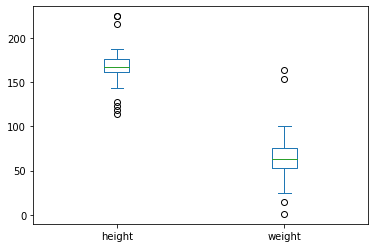

In [ ]:
# [6] 그래프 사용하여 이상치 확인
import matplotlib.pyplot as plt
Xoutlier.plot(kind='box')
plt.show()

In [ ]:
# [7] 각 feature별 Q1, Q3 확인
Xoutlier.quantile([0.25, 0.75])

,height,weight
0.25,162.00,52.75
0.75,175.85,75.00


In [ ]:
# [8] height에 대한 outlier 확인
Q1, Q3 = Xoutlier['height'].quantile([0.25, 0.75])
IQR = Q3 - Q1
lower_h = round(Q1 - IQR*1.5, 3)
upper_h = round(Q3 + IQR*1.5, 3)
print(lower_h, upper_h)

141.225 196.625


In [ ]:
# [9] weight에 대한 outlier 확인
Q1, Q3 = Xoutlier['weight'].quantile([0.25, 0.75])
IQR = Q3 - Q1
lower_w = round(Q1 - IQR*1.5, 3)
upper_w = round(Q3 + IQR*1.5, 3)
print(lower_w, upper_w)

19.375 108.375


In [ ]:
# [10] height에 대한 outlier 제거 및 학습
height = Xoutlier['height']
outlier_h = Xoutlier[(height < lower_h) | (height > upper_h)]
#print(outlier_h)
Xoutlier_rh = Xoutlier.drop(index=outlier_h.index)
Youtlier_rh = Youtlier.drop(index=outlier_h.index)
#print(Xoutlier_rh.shape, Youtlier_rh.shape)
model3 = LinearRegression()
Model_Train(model3, Xoutlier_rh, Youtlier_rh)

0.9868 0.9935


LinearRegression()

In [ ]:
# [11] weight에 대한 outlier 제거 및 학습
weight = Xoutlier['weight']
outlier_w = Xoutlier[(weight < lower_w) | (weight > upper_w)]
print(outlier_w)
Xoutlier_rw = Xoutlier.drop(index=outlier_w.index)
Youtlier_rw = Youtlier.drop(index=outlier_w.index)
print(Xoutlier_rw.shape, Youtlier_rw.shape)
model4 = LinearRegression()
Model_Train(model4, Xoutlier_rw, Youtlier_rw)

     height  weight
102   127.6     0.9
104   216.3   154.0
105   224.6   164.1
106   224.5    14.0
(103, 2) (103,)
0.9731 0.9217


LinearRegression()

### 2-4.Polynomial Regression
- 다항 회귀
- 비선형 데이터 집합을 모델링 할 때 사용
- 곡선의 다항식 선을 사용함
- 과대적합이 나타나기 쉬움
- $y = \beta_{0} + \beta_{1} x_{1} + \beta_{2} x_{2} + \beta_{3} x_{1}^{2} + \beta_{4} x_{2}^{2} ...+ \epsilon$
- X를 다항식으로 변경하여 모델링의 데이터로 사용함

In [ ]:
# sklearn.preprocessing.PolynomialFeatures(degree=2, *, 
#               interaction_only=False, include_bias=True, order='C')

In [ ]:
# [12] PolynomialFeatures 사용하여 2차항이 포함되도록 
# Xnormal을 변환 함 (PolynomialFeatures에 poly2, 변환 결과에 Xpoly2 이름 부여)
from sklearn.preprocessing import PolynomialFeatures
poly2 = PolynomialFeatures(degree=2, include_bias=False) #, interaction_only=True)
Xpoly2 = poly2.fit_transform(Xnormal)
model = LinearRegression()
Model_Train(model, Xpoly2, Ynormal)

1.0000 0.9988


LinearRegression()

In [ ]:
# [13] Xpoly2의 shape 확인
print(Xnormal.shape, Xpoly2.shape)

(100, 2) (100, 5)


In [ ]:
# [14] poly2의 feature_names 확인
poly2.get_feature_names_out()

array(['height', 'weight', 'height^2', 'height weight', 'weight^2'],
      dtype=object)

In [ ]:
# [15] Xpoly2의 상관계수 확인 
pd.DataFrame(Xpoly2).corr()

,0,1,2,3,4
0,1.000000,0.604015,0.999526,0.715850,0.602221
1,0.604015,1.000000,0.605356,0.987694,0.992038
2,0.999526,0.605356,1.000000,0.717912,0.605105
3,0.715850,0.987694,0.717912,1.000000,0.984456
4,0.602221,0.992038,0.605105,0.984456,1.000000


In [ ]:
Xpoly2[:5]

array([[  163.1 ,    71.3 , 26601.61, 11629.03,  5083.69],
       [  175.1 ,    85.5 , 30660.01, 14971.05,  7310.25],
       [  174.  ,    78.  , 30276.  , 13572.  ,  6084.  ],
       [  171.2 ,    73.1 , 29309.44, 12514.72,  5343.61],
       [  160.2 ,    57.4 , 25664.04,  9195.48,  3294.76]])

In [ ]:
# [16] PolynomialFeatures 사용하여 3차항이 포함되도록
# Xnormal을 변환 함 (PolynomialFeatures에 poly3, 변환 결과에 Xpoly3 이름 부여)
poly3 = PolynomialFeatures(degree=3, include_bias=False) #, interaction_only=True)
Xpoly3 = poly3.fit_transform(Xnormal)
model = LinearRegression()
Model_Train(model, Xpoly3, Ynormal)

1.0000 1.0000


LinearRegression()

In [ ]:
# [17] Xpoly3의 shape 확인
print(Xpoly3.shape)

(100, 9)


In [ ]:
# [18] poly3의 shape 확인
poly3.get_feature_names_out()

array(['height', 'weight', 'height^2', 'height weight', 'weight^2',
       'height^3', 'height^2 weight', 'height weight^2', 'weight^3'],
      dtype=object)

In [ ]:
Xpoly3[:5]

array([[1.63100000e+02, 7.13000000e+01, 2.66016100e+04, 1.16290300e+04,
        5.08369000e+03, 4.33872259e+06, 1.89669479e+06, 8.29149839e+05,
        3.62467097e+05],
       [1.75100000e+02, 8.55000000e+01, 3.06600100e+04, 1.49710500e+04,
        7.31025000e+03, 5.36856775e+06, 2.62143085e+06, 1.28002477e+06,
        6.25026375e+05],
       [1.74000000e+02, 7.80000000e+01, 3.02760000e+04, 1.35720000e+04,
        6.08400000e+03, 5.26802400e+06, 2.36152800e+06, 1.05861600e+06,
        4.74552000e+05],
       [1.71200000e+02, 7.31000000e+01, 2.93094400e+04, 1.25147200e+04,
        5.34361000e+03, 5.01777613e+06, 2.14252006e+06, 9.14826032e+05,
        3.90617891e+05],
       [1.60200000e+02, 5.74000000e+01, 2.56640400e+04, 9.19548000e+03,
        3.29476000e+03, 4.11137921e+06, 1.47311590e+06, 5.27820552e+05,
        1.89119224e+05]])

### 2-5.Ridge Regression
- sklearn.linear_model.Ridge(alpha=1.0, *, fit_intercept=True, normalize='deprecated', copy_X=True, max_iter=None, tol=0.001, solver='auto', positive=False, random_state=None)
- coef(회귀계수)가 작아지지만 0이 되지는 않음

In [ ]:
# alpha=0 : 규제를 주지 않음
# alpha 값이 크다는 것은 규제를 크게 주겠다는 것을 의미 => coef_ 값들이 작아짐

In [ ]:
# [19] PolynomialFeatures degree=3과 Ridge를 사용한 모델링
# 권장 순서
# X -> Xscaled -> Xpoly -> fit()

from sklearn.linear_model import Ridge
Xscaled = MinMaxScaler().fit_transform(Xnormal)
poly3 = PolynomialFeatures(degree=3, include_bias=False) #, interaction_only=True)
Xpoly3 = poly3.fit_transform(Xscaled)
ridge_coef = pd.DataFrame()
for a in [0, 0.001, 0.1, 1, 10]:
    print(f'alpha={a:7.4f}', end='  ')
    model = Ridge(alpha=a, random_state=0)    
    Model_Train(model, Xpoly3, Ynormal)
    ridge_coef[f'alpha_{a}'] = model.coef_

alpha= 0.0000  1.0000 1.0000
alpha= 0.0010  0.9999 0.9977
alpha= 0.1000  0.9890 0.9754
alpha= 1.0000  0.9108 0.9137
alpha=10.0000  0.5942 0.5457


In [ ]:
'''
alpha= 0.0000  1.0000 1.0000
alpha= 0.0010  0.9994 0.9962
alpha= 0.1000  0.9874 0.9499
alpha= 1.0000  0.9480 0.9279
alpha=10.0000  0.6938 0.6471
'''

In [ ]:
# [20] ridge_coef 출력하여 회귀계수 확인
ridge_coef

,alpha_0,alpha_0.001,alpha_0.1,alpha_1,alpha_10
0,-73.109478,-14.770202,-4.350133,-3.449517,-0.663046
1,131.354160,31.716423,11.090243,5.414167,2.308375
2,141.656039,-2.088447,-4.659543,-3.527552,-0.664110
3,-209.987752,1.363581,6.050911,3.443241,1.758562
4,0.799485,11.453945,4.517197,4.032551,2.143902
5,-69.080548,10.829774,-4.981092,-3.595744,-0.662633
6,94.806642,-14.604358,2.300521,1.985839,1.335582
7,-1.086255,-11.450236,1.205406,3.002338,1.903592
8,0.109442,-1.314782,-1.817746,2.610686,1.922268


In [ ]:
ridge_coef.abs().sum()

alpha_0        721.989800
alpha_0.001     99.591749
alpha_0.1       40.972792
alpha_1         31.061635
alpha_10        13.362070
dtype: float64

### 2-6.Lasso Regression
- sklearn.linear_model.Lasso(alpha=1.0, *, fit_intercept=True, normalize='deprecated', precompute=False, copy_X=True, max_iter=1000, tol=0.0001, warm_start=False, positive=False, random_state=None, selection='cyclic')
- 규제강도가 커지면 회귀계수가 작아지고 0도 될 수 있다

In [ ]:
# 권장 순서
# X -> Xscaled -> Xpoly -> fit()
tX = pd.DataFrame({'A': [1, 10, 100, 1000, 10000, 100000]})
tS = MinMaxScaler().fit_transform(tX)  # ndarray
t4 = tS ** 4
t4

array([[0.00000000e+00],
       [6.56126245e-17],
       [9.60634435e-13],
       [9.96045837e-09],
       [9.99640045e-05],
       [1.00000000e+00]])

In [ ]:
# 비권장 순서
# X -> Xpoly -> Xscaled -> fit()
tX = pd.DataFrame({'A': [1, 10, 100, 1000, 10000, 100000]})
t4 = tX ** 4
t4['A']

0                      1
1                  10000
2              100000000
3          1000000000000
4      10000000000000000
5    7766279631452241920
Name: A, dtype: int64

In [ ]:
A = 1e20
type(A)

float

In [ ]:
# int64
-2**63, 2**63-1   # 9223372036854775807

(-9223372036854775808, 9223372036854775807)

In [ ]:
# [21] degree=3과 Lasso를 사용한 모델링
# 권장 순서
# X -> Xscaled -> Xpoly -> fit()
from sklearn.linear_model import Lasso
Xscaled = MinMaxScaler().fit_transform(Xnormal)
poly3 = PolynomialFeatures(degree=3, include_bias=False) #, interaction_only=True)
Xpoly3 = poly3.fit_transform(Xscaled)
lasso_coef = pd.DataFrame()
for a in [0.0001, 0.001, 0.1, 0.2, 0.3]:
    print(f'alpha={a:7.4f}', end='  ')
    model = Lasso(alpha=a, max_iter=1000, tol=0.001, random_state=0)    
    Model_Train(model, Xpoly3, Ynormal)
    lasso_coef[f'alpha_{a}'] = model.coef_

alpha= 0.0001  0.9998 0.9985
alpha= 0.0010  0.9994 0.9986
alpha= 0.1000  0.9253 0.9262
alpha= 0.2000  0.7656 0.6763
alpha= 0.3000  0.7096 0.6361


In [ ]:
'''
alpha= 0.0001  0.9979 0.9938
alpha= 0.0010  0.9964 0.9851
alpha= 0.1000  0.9246 0.9180
alpha= 0.2000  0.7656 0.6763
alpha= 0.3000  0.7096 0.6361
'''

In [ ]:
# [22] lasso_coef 출력하여 회귀계수 확인
lasso_coef

,alpha_0.0001,alpha_0.001,alpha_0.1,alpha_0.2,alpha_0.3
0,4.805105,-0.000000,-0.000000,-0.000000,-0.000000
1,33.607995,26.482969,17.107670,12.632765,10.690377
2,-17.123098,-11.091911,-0.000000,-0.000000,-0.000000
3,-2.296627,-0.160488,0.000000,0.000000,0.000000
4,0.000000,-0.000000,0.000000,0.000000,0.000000
5,4.748478,-0.000000,-5.281175,-0.000000,-0.000000
6,-10.289303,-1.800514,0.000000,0.000000,0.000000
7,-1.541214,-1.008017,0.000000,0.000000,0.000000
8,-0.905310,-2.147514,0.000000,0.000000,0.000000


2-7.DecisionTree 
- sklearn.tree.DecisionTreeRegressor(*, criterion='squared_error', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, ccp_alpha=0.0

In [ ]:
# [22] Xnormal, Ynormal 데이터에 DecisionTreeRegressor 사용
from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor(max_depth=8, random_state=0)
Model_Train(model, Xnormal, Ynormal)

0.9999 0.7974


DecisionTreeRegressor(max_depth=8, random_state=0)

In [ ]:
# train  test   
# 1.0000 0.7371  => overfitting, 과대적합
# 과대적합 해결방법 => Ridge, Lasso, 앙상블
#                      데이터의 크기를 늘리는 것, 함수의 parameter에 값을 변경

In [ ]:
# Ridge, Lasso는 overfitting 되는 데이터에 주로 사용하여 overfitting을 해결하는 용도로 사용한다

In [ ]:
# [23] 데이터의 개수를 2000개로 늘려 DecisionTreeRegressor 사용 
dataL = make_sample(1234, 2000)
Xlarge = dataL[['height', 'weight']]
Ylarge = dataL['BMI']
model = DecisionTreeRegressor(random_state=0)
Model_Train(model, Xlarge, Ylarge)

1.0000 0.9903


DecisionTreeRegressor(random_state=0)

### 2-7.앙상블

- sklearn.ensemble.RandomForestRegressor(n_estimators=100, *, criterion='squared_error', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, ccp_alpha=0.0, max_samples=None)
- https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn

In [ ]:
# [24] Xnormal, Ynormal 데이터에 RandomForestRegressor 사용
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(random_state=0)
Model_Train(model, Xnormal, Ynormal)  # 100개!

0.9897 0.8219


RandomForestRegressor(random_state=0)

In [ ]:
# [25] Xnormal을 2차식으로 만든 후 RandomForestRegressor 사용
poly2 = PolynomialFeatures(degree=2, include_bias=False) #, interaction_only=True)
Xpoly2 = poly2.fit_transform(Xnormal)
model = RandomForestRegressor(random_state=0)
Model_Train(model, Xpoly2, Ynormal)  # 100개!

0.9890 0.8020


RandomForestRegressor(random_state=0)

In [ ]:
# [26] 데이터의 개수를 2000개로 늘려 RandomForestRegressor 사용
dataL = make_sample(1234, 2000)     # 150개 이상만 되어도 좋은 결과
Xlarge = dataL[['height', 'weight']]
Ylarge = dataL['BMI']
model = RandomForestRegressor(random_state=0)
Model_Train(model, Xlarge, Ylarge)  # 2000개!

0.9994 0.9967


RandomForestRegressor(random_state=0)

- XBGRegressor : max_depth=3, learning_rate=0.1, n_estimators=100, verbosity=1, silent=None, objective="reg:linear", booster='gbtree', n_jobs=1, nthread=None, gamma=0, min_child_weight=1, max_delta_step=0, subsample=1, colsample_bytree=1, colsample_bylevel=1, colsample_bynode=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, base_score=0.5, random_state=0, seed=None, missing=None, importance_type="gain", **kwargs) 

In [ ]:
# [27] Xnormal, Ynormal 데이터에 XGBRegressor 사용
from xgboost import XGBRegressor
model = XGBRegressor(objective='reg:squarederror', random_state=0)
Model_Train(model, Xnormal, Ynormal)  # 100개!

0.9980 0.9157


XGBRegressor(objective='reg:squarederror')

In [ ]:
# [28] 데이터의 개수를 2000개로 늘려 XGBRegressor 사용
dataL = make_sample(1234, 2000)     # 150개 이상만 되어도 좋은 결과
Xlarge = dataL[['height', 'weight']]
Ylarge = dataL['BMI']
model = XGBRegressor(n_estimators=900, objective='reg:squarederror', random_state=0)
Model_Train(model, Xlarge, Ylarge)  # 2000개!

0.9997 0.9978


XGBRegressor(n_estimators=900, objective='reg:squarederror')

## 3.회귀 모델 성능평가

- $R^2$ score
  - model.score(X, y)
  - sklearn.metrics.r2_score(y_true, y_pred)
  - 분산 기반으로 예측 성능을 평가
  - 예측값 분산 / 실제값 분산
- MAE(Mean Absolute Error)
   - sklearn.metrics.mean_absolute_error(y_true, y_pred)
   - 실제 값과 예측 값의 차이를 절댓값으로 변환해 평균한 것
- MSE(Mean Squared Error)
   - sklearn.metrics.mean_squared_error(y_true, y_pred)  
   - 실제 값과 예측 값의 차이를 제곱해 평균한 것
- RMSE(Root Mean Squared Error)
   - sklearn API에 없음
   - MSE에 np.sqrt() 또는 ** 0.5를 사용함
   - MSE 값은 오류의 제곱을 구하므로 실제 오류 평균보다 더 커지는 특성이 있어 MSE에 루트를 씌운 것
- MSLE(Mean Squared Log Error)
   - sklearn.metrics.mean_squared_log_error(y_true, y_pred)
   - MSE에 로그를 적용해준 지표
- RMSLE(Root Mean Square Log Error) 
   - RMSE에 로그를 적용해준 지표
   - 이상치가 있더라도 변동폭이 크지 않음(이상치에 강건함)
   - 실제값보다 예측값이 작을 때 더 큰 패널티 부여
   - 작게 예측하면 안되는 경우 사용하면 좋음 (배달 시간 예측)
   - 실제값, 예측값에 음수가 있으면 안됨 (오류 발생)
- 참조 : https://bkshin.tistory.com/entry/%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D-17-%ED%9A%8C%EA%B7%80-%ED%8F%89%EA%B0%80-%EC%A7%80%ED%91%9C

In [ ]:
# R2_score : 1에 가까울 수록 좋은 성능
# MAE, MSE, RMSE, MSLE, RMSLE :  0에 가까울 수록 좋은 성능 

### 3-1.성능평가 함수

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_squared_log_error as msle

# [29] r2_score, mae, mse, rmse, msle, rmsle 를 구해 반환하는 함수를 작성합니다.
# 한 개의 행에 6가지 성능평가 결과를 소수점 아래 4자리까지 표시되도록 하여 작성합니다.
def get_scores(model, X, Y):
    pred = model.predict(X)   

    # 음수가 있어도 상관없음
    A = r2_score(Y, pred)
    B = mae(Y, pred)
    C = mse(Y, pred)    
    E = np.sqrt(C)   # rmse

    # msle, rmsle 는 음수가 있어서는 안됨
    #pred[0] = -2
    pred = np.where(pred<0, 0, pred)
    #print(pred[0])
    D = msle(Y, pred)    
    F = np.sqrt(D)   # rmsle
    return f'r2: {A:.4} mae: {B:.4} mse: {C:.4} msle: {D:.4} rmse: {E:.4} rmsle: {F:.4}'

### 3-2.모델링 함수

In [ ]:
# [30] Model_Train함수를 수정해서 
# train, test에 대한 6가지 성능평가 결과를 출력하는 Model_Train2 함수를 작성합니다.
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

def Model_Train_2(model, XF, YF, scale=False):
    # 7:3 분리, random_state=321  (주의: stratify사용 안함 -> 분류 모델에서만 사용)
    if scale:
        XF = MinMaxScaler().fit_transform(XF)
    xtrain, xtest, ytrain, ytest = train_test_split(XF, YF, 
                                                    test_size=0.3, 
                                                    random_state=321)
    model.fit(xtrain, ytrain)
    #  코드 추가 부분
    print(model.__class__)
    print('train:', get_scores(model, xtrain, ytrain))
    print('test:', get_scores(model, xtest, ytest))
    print()
    return model

### 3-3.여러 모델 적용

In [ ]:
# [31] Xnormal, Ynormal 데이터 사용, LinearRegression => model1
model1 = LinearRegression()
Model_Train_2(model1, Xnormal, Ynormal)

train: r2: 0.9931 mae: 0.2648 mse: 0.12 msle: 0.0002734 rmse: 0.3464 rmsle: 0.01653
test: r2: 0.9625 mae: 0.3783 mse: 0.3626 msle: 0.0009766 rmse: 0.6022 rmsle: 0.03125


LinearRegression()

In [ ]:
# 음수값을 임의로 0으로 수정한 경우 msle, rmsle의 값이 커짐
# train: r2: 0.9931 mae: 0.2648 mse: 0.12 msle: 0.1763 rmse: 0.3464 rmsle: 0.4199
# test: r2: 0.9625 mae: 0.3783 mse: 0.3626 msle: 0.3443 rmse: 0.6022 rmsle: 0.5868

In [ ]:
# [32] Xpoly3, Ynormal 데이터 사용, LinearRegression => model2
poly3 = PolynomialFeatures(degree=3, include_bias=False) #, interaction_only=True)
Xpoly3 = poly3.fit_transform(Xnormal)
model2 = LinearRegression()
print(Xpoly3.shape)
Model_Train_2(model2, Xpoly3, Ynormal)

(100, 9)
train: r2: 1.0 mae: 0.002813 mse: 1.09e-05 msle: 1.991e-08 rmse: 0.003302 rmsle: 0.0001411
test: r2: 1.0 mae: 0.006752 mse: 0.0004418 msle: 1.257e-06 rmse: 0.02102 rmsle: 0.001121


LinearRegression()

In [ ]:
# [33] Xlarge, Ylarge 데이터 사용, XGBRegressor => model3
dataL = make_sample(1234, 2000)     
Xlarge = dataL[['height', 'weight']]
Ylarge = dataL['BMI']
model3 = XGBRegressor(n_estimators=900, objective='reg:squarederror', random_state=0)
Model_Train_2(model3, Xlarge, Ylarge)  # 2000개!

train: r2: 0.9997 mae: 0.05245 mse: 0.004918 msle: 8.916e-06 rmse: 0.07013 rmsle: 0.002986
test: r2: 0.9978 mae: 0.1144 mse: 0.03039 msle: 5.758e-05 rmse: 0.1743 rmsle: 0.007588


XGBRegressor(n_estimators=900, objective='reg:squarederror')

In [ ]:
# [34] X_submission, Y_hidden 데이터를 사용하여 model1, model2, model3의 성능을 평가하여봄 
# (실제는 할 수 없음)
XF = X_submission[['height', 'weight']]
YF = Y_hidden['BMI']
XFpoly3 = poly3.fit_transform(XF)
print(get_scores(model1, XF, YF))
print(get_scores(model2, XFpoly3, YF))
print(get_scores(model3, XF, YF))

r2: 0.9892 mae: 0.2701 mse: 0.1499 msle: 0.0003649 rmse: 0.3871 rmsle: 0.0191
r2: 1.0 mae: 0.003643 mse: 2.242e-05 msle: 4.639e-08 rmse: 0.004735 rmsle: 0.0002154
r2: 0.998 mae: 0.1184 mse: 0.02824 msle: 5.373e-05 rmse: 0.168 rmsle: 0.00733


In [ ]:
# [35] 제출파일 만들기 (실제 문제에서 요구하는 형태로 작성해야 함)
# msle, rmsle (음수가 있으면 안됨) 
pred = model2.predict(XFpoly3)
submission = pd.DataFrame({'ID': X_submission['ID'],
                           'BMI': pred})
#submission.head()
submission.to_csv('0001100.csv', index=False)

## 4.웹사이트 방문자 예측

In [ ]:
!git clone https://github.com/Soyoung-Yoon/bigdata

Cloning into 'bigdata'...
remote: Enumerating objects: 41, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 41 (delta 11), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (41/41), done.


### 4-1. 데이터 이해, 생성
- 1개 데이터를 나누어 시험용으로 변경해 보는 작업
- 실제 시험에서는 이런 과정은 필요 없음


In [ ]:
# https://www.kaggle.com/bobnau/daily-website-visitors
# Daily number of pages loaded
# Daily number of visitors from whose IP addresses there haven't been hits on any page in over 6 hours
# Number of unique visitors who do not have a cookie identifying them as a previous customer
# Number of unique visitors minus first time visitors

In [ ]:
# [0] 사용 라이브러리 import
import pandas as pd

# 데이타가 많은경우 모두 출력 안되고 ... 으로 생략해서 출력됨.
# 시험환경에서는 아래와 같이 해야해서 수정했습니다 ^^*
pd.options.display.max_rows = 500     #출력할 max row를 지정
pd.options.display.max_columns = 20   #출력할 max columns를 지정
#출력 format 지정 - 소수점아래 4자리까지
pd.set_option('display.float_format', '{:.4f}'.format)

In [ ]:
# [1] 'bigdata/daily-website-visitors.csv' 파일 불러오기, shape 확인하기

df = pd.read_csv('bigdata/daily-website-visitors.csv')
df.shape  # 행, 열 정보

(2167, 8)

In [ ]:
# [2] head를 사용해 데이터의 모습 확인
# 컬럼명이 대소문자 섞여 있어 사용하기 좋지 않음 
print(df.head(2))

   Row     Day  Day.Of.Week       Date Page.Loads Unique.Visits  \
0    1  Sunday            1  9/14/2014      2,146         1,582   
1    2  Monday            2  9/15/2014      3,621         2,528   

  First.Time.Visits Returning.Visits  
0             1,430              152  
1             2,297              231  


In [ ]:
# [3] 컬럼명 정리 - 소문자로 변경, '.'을 '-'로 변경
df.columns = df.columns.str.replace('.', '_', regex=True).str.lower()
df.columns

Index(['row', 'day', 'day_of_week', 'date', 'page_loads', 'unique_visits',
       'first_time_visits', 'returning_visits'],
      dtype='object')

컬럼 정보
- row : 1번 부터 시작하는 일련번호
- day : 요일 정보
- day_of_week : 요일 정보
- date : 날짜 정보
- page_loads : 로드된 일별 페이지 수
- unique_visits : 6시간 이상 페이지에서 조회되지 않은 IP 주소의 일일 방문자 수 (종속변수)
- first_time_visits : 이전 고객으로 식별되는 쿠키를 가지고 있지 않은 고유 방문자 수
- returning_visits : unique_visits 수에서 first_time_visits 제외

In [ ]:
 df.dtypes

row                   int64
day                  object
day_of_week           int64
date                 object
page_loads           object
unique_visits        object
first_time_visits    object
returning_visits     object
dtype: object

In [ ]:
# [4] unique_visits를 예측하는 값으로 사용할 것이며, 수치데이터 이어야 함
# 콤마 제거 후, int로 형변환
df['unique_visits'] = df['unique_visits'].replace(',', '', regex=True).astype(int)

In [ ]:
# [5] 시험 형식으로 train, test 데이터로 나누어 저장합니다.  (6:4 비율)
train_size = len(df) - int(len(df)*0.4)

# 여러 가지 데이터가 고루 섞이도록 해야 함
df = df.sample(frac=1, random_state=1234)
df['row'] = range(1, len(df) + 1)
train = df.iloc[:train_size, :]
test = df.iloc[train_size:, :]
print(train.shape, test.shape)
y = 'unique_visits'
X_train = train.drop(columns=y)
Y_train = train[['row', y]]
X_test = test.drop(columns=y)
Y_test = test[['row', y]]
X_train.to_csv('x_train.csv', index=False)
Y_train.to_csv('y_train.csv', index=False)
X_test.to_csv('x_test.csv', index=False)
Y_test.to_csv('y_test.csv', index=False)

(1301, 8) (866, 8)


### 4-2. 데이터 불러오기, 전처리

In [ ]:
# [1] 데이터 파일 불러오기
X_use = pd.read_csv('x_train.csv')
X_submission = pd.read_csv('x_test.csv')
Y = pd.read_csv('y_train.csv')
Y_hidden = pd.read_csv('y_test.csv')  # 시험에는 제공 안됨

In [ ]:
# [2] dfX 만들기, dfX의 info() 확인
# use, submission 데이터를 묶어 전처리 하기 위함
dfX = pd.concat([X_use, X_submission], ignore_index=True, axis=0)
dfX.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2167 entries, 0 to 2166
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   row                2167 non-null   int64 
 1   day                2167 non-null   object
 2   day_of_week        2167 non-null   int64 
 3   date               2167 non-null   object
 4   page_loads         2167 non-null   object
 5   first_time_visits  2167 non-null   object
 6   returning_visits   2167 non-null   object
dtypes: int64(2), object(5)
memory usage: 118.6+ KB


In [ ]:
# [3] dfX의 object 값이 어떤 것인지 확인하기 위해 5줄 출력을 합니다.
dfX.head(5)

,row,day,day_of_week,date,page_loads,first_time_visits,returning_visits
0,1,Friday,6,6/26/2020,"3,555","2,248",427
1,2,Thursday,5,8/29/2019,"4,221","2,477",505
2,3,Friday,6,11/18/2016,"4,767","2,734",690
3,4,Saturday,7,11/30/2019,"3,301","2,053",390
4,5,Sunday,1,7/5/2020,"2,948","1,836",362


In [ ]:
# [4] 'page_loads', 'first_time_visits', 'returning_visits' 에 대해서 
#  콤마를 없애고, int로 형변환 합니다
#dfX['page_loads'].str.replace(',', '', regex=True).astype(int)
names = ['page_loads', 'first_time_visits', 'returning_visits']
dfX[names] = dfX[names].replace(',', '', regex=True).astype(int)
dfX.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2167 entries, 0 to 2166
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   row                2167 non-null   int64 
 1   day                2167 non-null   object
 2   day_of_week        2167 non-null   int64 
 3   date               2167 non-null   object
 4   page_loads         2167 non-null   int64 
 5   first_time_visits  2167 non-null   int64 
 6   returning_visits   2167 non-null   int64 
dtypes: int64(5), object(2)
memory usage: 118.6+ KB


In [ ]:
# [5] 'date'에 대해서 datetime64로 형변환 합니다.
#dfX['date'] = dfX['date'].astype('datetime64')
dfX['date'] = pd.to_datetime(dfX['date'], format='%m/%d/%Y')

In [ ]:
# [6] 형변환이 올바르게 되었는지 확인합니다.
dfX.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2167 entries, 0 to 2166
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   row                2167 non-null   int64         
 1   day                2167 non-null   object        
 2   day_of_week        2167 non-null   int64         
 3   date               2167 non-null   datetime64[ns]
 4   page_loads         2167 non-null   int64         
 5   first_time_visits  2167 non-null   int64         
 6   returning_visits   2167 non-null   int64         
dtypes: datetime64[ns](1), int64(5), object(1)
memory usage: 118.6+ KB


In [ ]:
# [7] day, day_of_week를 확인해 보면 동일한 데이터 인 것을 알 수 있음
# 'day' 컬럼을 제거합니다.
dfX2 = dfX.drop(columns='day')

In [ ]:
# [8] 'date'에서 'year', 'month', 'day'에 대한 정보를 dfX2에 포함시키고,
# 'date' 를 제거합니다.
# 상황에 따라 'quarter' 사용도 고려할 수 있음, 주말/주중으로 나눌 수도 있음 ...  
date = pd.DataFrame()
temp = dfX2['date'].dt
date['year'] = temp.year
date['month'] = temp.month
date['day'] = temp.day
dfX3 = dfX2.drop(columns='date')
dfX3 = pd.concat([dfX3, date], axis=1)
dfX3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2167 entries, 0 to 2166
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   row                2167 non-null   int64
 1   day_of_week        2167 non-null   int64
 2   page_loads         2167 non-null   int64
 3   first_time_visits  2167 non-null   int64
 4   returning_visits   2167 non-null   int64
 5   year               2167 non-null   int64
 6   month              2167 non-null   int64
 7   day                2167 non-null   int64
dtypes: int64(8)
memory usage: 135.6 KB


In [ ]:
# [9] dfX3과 Y를 merge 합니다.
# Y와 X의 feature의 관계를 분석해 보기 위해!
dfXY = pd.merge(dfX3, Y)
print(dfXY.shape, dfX3.shape, Y.shape)

(1301, 9) (2167, 8) (1301, 2)


In [ ]:
# [10] dfXY의 상관계수를 확인한다
# 'unique_visits'와 상관이 매우 높은 feature들이 있음 (page_loads, first_time_visits, returning_visits)
print(dfXY.corr()['unique_visits'])

row                  0.0162
day_of_week         -0.2592
page_loads           0.9885
first_time_visits    0.9962
returning_visits     0.9059
year                 0.0707
month               -0.0478
day                 -0.0353
unique_visits        1.0000
Name: unique_visits, dtype: float64


In [ ]:
# [11] 'day_of_week' 별 'unique_visits'의 평균을 구해본다.
# 2, 3, 4, 5 가 높고 1, 6, 7이 낮은 것을 볼 수 있다.
temp = dfXY.groupby('day_of_week')['unique_visits'].mean()
temp

day_of_week
1   2351.3175
2   3487.1016
3   3590.0156
4   3454.6684
5   3362.2404
6   2680.1477
7   1784.1872
Name: unique_visits, dtype: float64

In [ ]:
# [12] 'day_of_week' 별 평균이 높은 것에 대한 데이터를 high_day_of_week로 저장
high_day_of_week = temp[temp > 3000].index.values
high_day_of_week

array([2, 3, 4, 5])

In [ ]:
# [13] 'month' 별 'unique_visits'의 평균을 구해본다.
# 2, 3, 4, 5, 10, 11이 높고 1, 6, 7이 낮은 것을 볼 수 있다.
temp = dfXY.groupby('month')['unique_visits'].mean()
temp

month
1    2504.1947
2    3164.8842
3    3306.5798
4    3835.3818
5    3324.8396
6    2619.0339
7    2315.3505
8    2266.5980
9    2668.1776
10   3188.5345
11   3445.1504
12   2776.1048
Name: unique_visits, dtype: float64

In [ ]:
# [14] 'month' 별 평균이 높은 것에 대한 데이터를 high_month로 저장
high_month = temp[temp > 3000].index.values
high_month

array([ 2,  3,  4,  5, 10, 11])

In [ ]:
dfX3['day_of_week'].isin(high_day_of_week)

In [ ]:
# [15] high_day_of_week, high_month의 index 정보를 사용해 파생 변수 생성
# dfX3에 높은 평균을 갖는 요일과 달을 1, 아닌 것을 0으로 하는 dow_h, month_h 변수 추가
import numpy as np
#dfX3['dow_h'] = np.where(dfX3['day_of_week'].isin(high_day_of_week), 1, 0)
dfX3['dow_h'] = dfX3['day_of_week'].isin(high_day_of_week).astype(int)
dfX3['month_h'] = dfX3['month'].isin(high_month).astype(int)
dfX3.head(3)

,row,day_of_week,page_loads,first_time_visits,returning_visits,year,month,day,dow_h,month_h
0,1,6,3555,2248,427,2020,6,26,0,0
1,2,5,4221,2477,505,2019,8,29,1,0
2,3,6,4767,2734,690,2016,11,18,0,1


In [ ]:
temp = dfXY.groupby('year')['unique_visits'].mean()
temp

year
2014   2588.9322
2015   2946.1948
2016   3240.0045
2017   2502.0631
2018   3027.3835
2019   3069.0755
2020   3155.5333
Name: unique_visits, dtype: float64

### 4-3.성능평가, 모델링 함수


In [ ]:
#[16] 사용할 라이브러리 import
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge, Lasso

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_squared_log_error as msle
import numpy as np  # 추가해야함

# [17] r2_train, r2_test, mae, mse, rmse, msle, rmsle 를 구해 
#      Series로 반환하는 함수를 작성합니다.
def get_scores2(model, xtrain, xtest, ytrain, ytest):
    pred1 = model.predict(xtrain)   # train
    pred2 = model.predict(xtest)    # test

    # 음수가 있어도 상관없음
    A1 = r2_score(ytrain, pred1)
    A2 = r2_score(ytest, pred2)
    B = mae(ytest, pred2)
    C = mse(ytest, pred2)    
    E = np.sqrt(C)   # rmse

    # msle, rmsle 는 음수가 있어서는 안됨
    pred2 = np.where(pred2<0, 0, pred2)
    D = msle(ytest, pred2)    
    F = np.sqrt(D)   # rmsle   
    data = [round(x, 4) for x in [A1, A2, B,C,D,E,F]]
    names = 'r2_train r2_test mae mse msle rmse rmsle'.split()
    scores = pd.Series(data, index=names)
    return  scores

In [ ]:
# [18] 다양한 모델을 만들고 성능을 출력하는 함수 작성
# 결과를 DataFrame으로 만듭니다
def make_models(xtrain, xtest, ytrain, ytest, n=300, RL=False):
    temp = pd.DataFrame()
    
    model1 = LinearRegression().fit(xtrain, ytrain)
    temp['model1'] = get_scores2(model1, xtrain, xtest, ytrain, ytest)

    if not RL:
        model2 = DecisionTreeRegressor(random_state=0).fit(xtrain, ytrain)  # overfitting 나기 쉬움
        temp['model2'] = get_scores2(model2, xtrain, xtest, ytrain, ytest)

        for d in range(3, 9):
            model2 = DecisionTreeRegressor(max_depth=d, random_state=0).fit(xtrain, ytrain)  
            temp[f'model2_{d}'] = get_scores2(model2, xtrain, xtest, ytrain, ytest)

        model3 = RandomForestRegressor(n, random_state=0).fit(xtrain, ytrain)  
        temp['model3'] = get_scores2(model3, xtrain, xtest, ytrain, ytest)

        for d in range(3, 9):
            model3 = RandomForestRegressor(n, max_depth=d, random_state=0).fit(xtrain, ytrain) 
            temp[f'model3_{d}'] = get_scores2(model3, xtrain, xtest, ytrain, ytest)

    model4 = XGBRegressor(objective='reg:squarederror').fit(xtrain, ytrain)  
    temp['model4'] = get_scores2(model4, xtrain, xtest, ytrain, ytest)

    if RL:
        for a in [0.01, 0.1, 1, 2]:
            model5 = Ridge(alpha=a).fit(xtrain, ytrain)  
            temp[f'model5_{a}'] = get_scores2(model5, xtrain, xtest, ytrain, ytest)

        for a in [0.01, 0.1, 1, 2]:
            model6 = Lasso(alpha=a).fit(xtrain, ytrain)  
            temp[f'model6_{a}'] = get_scores2(model6, xtrain, xtest, ytrain, ytest)


    temp = temp.T
    temp.insert(2, 'diff', (temp['r2_train'] - temp['r2_test']).abs())
  
    return temp

### 4-4.데이터 분리, 모델적용

In [ ]:
dfX3.columns

Index(['row', 'day_of_week', 'page_loads', 'first_time_visits',
       'returning_visits', 'year', 'month', 'day', 'dow_h', 'month_h'],
      dtype='object')

In [ ]:
# [19] 학습에 사용할 feature 선택, 
# dfX4로 저장
# 'page_loads','first_time_visits' => 이것을 사용하면 성능이 무지 좋아요. (높은 상관계수)
from sklearn.preprocessing import MinMaxScaler
Xfeatures = ['day_of_week',# 'page_loads', 'first_time_visits',
             'returning_visits', 'year', 'month', 'day', 'dow_h', 'month_h']
dfX4 = dfX3[Xfeatures]     
#dfX4 = MinMaxScaler().fit_transform(dfX4)  # dfX4 ndarray 객체
print(dfX4.shape, type(dfX4))

(2167, 9) <class 'pandas.core.frame.DataFrame'>


In [ ]:
# [20] dfX4 데이터를 X_use, X_submission 으로 다시 분리
# dfX4 분리에서는 X_use의 행의 개수 사용
# YF, Y_submissionF 생성  Y에서 'unique_visits'만 선택
train_size = len(X_use)
XF = dfX4[:train_size]  # 행 선택, ndarray, DataFrame 모두 가능
X_submissionF = dfX4[train_size:]  # 행 선택, 제출용
YF = Y['unique_visits']
Y_submissionF = Y_hidden['unique_visits']
print([x.shape for x in [XF, X_submissionF, YF, Y_submissionF]])

[(1301, 9), (866, 9), (1301,), (866,)]


In [ ]:
# [21] XF, YF 데이터를 사용하여 데이터를 분리하고 make_models를 호출합니다.
xtrain, xtest, ytrain, ytest = train_test_split(XF, YF,
                                                test_size = 0.3,
                                                random_state=1234)
print([x.shape for x in [xtrain, xtest, ytrain, ytest]])
models = make_models(xtrain, xtest, ytrain, ytest)
print(models)

[(910, 9), (391, 9), (910,), (391,)]
          r2_train  r2_test   diff      mae        mse   msle     rmse  rmsle
model1      1.0000   1.0000 0.0000   0.0000     0.0000 0.0000   0.0000 0.0000
model2      1.0000   0.9975 0.0025  39.0563  2642.2481 0.0005  51.4028 0.0215
model2_3    0.9694   0.9649 0.0045 151.7075 36633.5008 0.0072 191.3988 0.0848
model2_4    0.9878   0.9834 0.0044 102.8897 17365.1993 0.0033 131.7771 0.0572
model2_5    0.9942   0.9919 0.0023  73.4576  8447.5513 0.0013  91.9106 0.0364
model2_6    0.9971   0.9954 0.0017  55.6050  4830.4610 0.0008  69.5015 0.0279
model2_7    0.9988   0.9971 0.0017  44.0379  3030.8953 0.0005  55.0536 0.0225
model2_8    0.9995   0.9974 0.0021  40.5876  2683.5802 0.0005  51.8033 0.0212
model3      0.9998   0.9987 0.0011  23.3542  1308.1246 0.0002  36.1680 0.0134
model3_3    0.9839   0.9793 0.0046 108.3793 21616.8887 0.0048 147.0268 0.0690
model3_4    0.9934   0.9911 0.0023  72.7674  9276.9061 0.0016  96.3167 0.0397
model3_5    0.9978   0.9965

In [ ]:
# [22] 여러 가지 조건으로 정렬하고 평가할 수 있음
print(models.sort_values('rmsle').head(7))

          r2_train  r2_test   diff     mae       mse   msle    rmse  rmsle
model1      1.0000   1.0000 0.0000  0.0000    0.0000 0.0000  0.0000 0.0000
model3      0.9998   0.9987 0.0011 23.3542 1308.1246 0.0002 36.1680 0.0134
model3_8    0.9998   0.9987 0.0011 24.6561 1403.1602 0.0002 37.4588 0.0139
model4      0.9995   0.9990 0.0005 26.1193 1089.7873 0.0002 33.0119 0.0144
model3_7    0.9996   0.9985 0.0011 27.1176 1598.1403 0.0002 39.9767 0.0147
model3_6    0.9991   0.9980 0.0011 32.3724 2110.1491 0.0003 45.9364 0.0173
model2_8    0.9995   0.9974 0.0021 40.5876 2683.5802 0.0005 51.8033 0.0212


In [ ]:
# [23] Polynomial Regression  + Ridge, Lasso 실행
dfX4 = dfX3[Xfeatures]     
Xscaled = MinMaxScaler().fit_transform(dfX4)  # Xscaled ndarray 객체
Xpoly = PolynomialFeatures(degree=3).fit_transform(Xscaled)
XF2 = Xpoly[:train_size]  # 학습용
X_submissionF2 = Xpoly[train_size:]  # 제출용

xtrain2, xtest2, ytrain2, ytest2 = train_test_split(XF2, YF,
                                                    test_size = 0.3,
                                                    random_state=1234)
print([x.shape for x in [xtrain2, xtest2, ytrain2, ytest2]])

In [ ]:
models = make_models(xtrain2, xtest2, ytrain2, ytest2, RL=True)
print(models)

In [ ]:
# [24] 여러 가지 조건으로 정렬하고 평가할 수 있음
print(models.sort_values('rmsle'))

In [ ]:
# XF, YF
# model4      0.9694   0.9613 0.0081 152.6876  40391.0413 0.0058 200.9752 0.0764
# 번외  # model3      0.9998   0.9987 0.0011 23.3542    1308.1246 0.0002 36.1680  0.0134

# XF2, YF
# model6_0.1  0.9506   0.9563 0.0057 170.1574 45614.3617 0.0073 213.5752 0.0854

In [ ]:
# [TIP] 학습 중 warning 메시지 없애기
import warnings
warnings.filterwarnings('ignore')

### 4-5. 모델 선택, 결과 제출

In [ ]:
# [25] xtrain, ytrain으로 모델 학습시켜 model 로 저장
model = XGBRegressor(objective='reg:squarederror').fit(xtrain, ytrain)  
print(get_scores2(model, xtrain, xtest, ytrain, ytest))

r2_train       0.9694
r2_test        0.9613
mae          152.6876
mse        40391.0413
msle           0.0058
rmse         200.9752
rmsle          0.0764
dtype: float64


In [ ]:
# [26] X_submissionF 데이터로 pred 구하고 submission DataFrame 생성
pred = model.predict(X_submissionF)
submission = pd.DataFrame({'row': X_submission['row'],
                           'unique_visits': pred})
submission.head()

In [ ]:
# [27] xtrain2, ytrain2으로 모델 학습시켜 model 로 저장
model = Lasso(alpha=0.1).fit(xtrain2, ytrain2)  
print(get_scores2(model, xtrain2, xtest2, ytrain2, ytest2))

r2_train       0.9506
r2_test        0.9563
mae          170.1574
mse        45614.3617
msle           0.0073
rmse         213.5752
rmsle          0.0854
dtype: float64


In [ ]:
# [28] X_submissionF2 데이터로 pred 구하고 submission DataFrame 생성
pred = model.predict(X_submissionF2)
submission = pd.DataFrame({'row': X_submission['row'],
                           'unique_visits': pred})
submission.head()

,row,unique_visits
1301,1302,2709.0922
1302,1303,4148.5377
1303,1304,3254.5924
1304,1305,2722.0792
1305,1306,1247.5313


In [ ]:
# [29] 파일로 저장
submission.to_csv('00001000.csv', index=False)

In [ ]:
# ^^!  앗    Y_hidden을 사용안해봤네요.
# 아래와 같이 사용하실 수 있습니다. (Lasso Model 인 경우)
print(get_scores2(model, XF2, X_submissionF2, YF, Y_submissionF))

### 4-6.시험보러 가서는 이렇게
- 필수 작업만 복사해 보겠습니다.

In [ ]:
# 실제 작업 - 복잡하게 했을 때 보다 성능이 더 좋아진것 같네요 ^^!

# import 를 쭈우욱!! 작성
import pandas as pd
# 시험환경에서는 아래와 같이 해야해서 수정했습니다 ^^*
pd.options.display.max_rows = 500     #출력할 max row를 지정
pd.options.display.max_columns = 20   #출력할 max columns를 지정

pd.set_option('display.float_format', '{:.4f}'.format)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_squared_log_error as msle
import numpy as np  # 추가해야함

# 함수들은 만들어야 합니다.

def get_scores_f(model, xtrain, xtest, ytrain, ytest):
    pred1 = model.predict(xtrain)   # train
    pred2 = model.predict(xtest)    # test

    # 음수가 있어도 상관없음
    A1 = r2_score(ytrain, pred1)
    A2 = r2_score(ytest, pred2)
    # msle, rmsle 는 음수가 있어서는 안됨
    pred2 = np.where(pred2<0, 0, pred2)
    B = msle(ytest, pred2)    
    C = np.sqrt(B)   # rmsle   
    data = [round(x, 4) for x in [A1, A2, C]]
    names = 'r2_train r2_test rmsle'.split()
    scores = pd.Series(data, index=names)
    return  scores

# 앗 ^^  내부의 함수 이름도 바꾸었어야 하는데 강의에서 바꾸지 않았었네요 
# get_scores_f!
def make_models_f(xtrain, xtest, ytrain, ytest, n=300):
    temp = pd.DataFrame()
    
    model1 = LinearRegression().fit(xtrain, ytrain)
    temp['model1'] = get_scores_f(model1, xtrain, xtest, ytrain, ytest)

    model2 = DecisionTreeRegressor(random_state=0).fit(xtrain, ytrain)  # overfitting 나기 쉬움
    temp['model2'] = get_scores_f(model2, xtrain, xtest, ytrain, ytest)

    for d in range(3, 9):
        model2 = DecisionTreeRegressor(max_depth=d, random_state=0).fit(xtrain, ytrain)  
        temp[f'model2_{d}'] = get_scores_f(model2, xtrain, xtest, ytrain, ytest)

    model3 = RandomForestRegressor(n, random_state=0).fit(xtrain, ytrain)  
    temp['model3'] = get_scores_f(model3, xtrain, xtest, ytrain, ytest)

    for d in range(3, 9):
        model3 = RandomForestRegressor(n, max_depth=d, random_state=0).fit(xtrain, ytrain) 
        temp[f'model3_{d}'] = get_scores_f(model3, xtrain, xtest, ytrain, ytest)

    model4 = XGBRegressor(objective='reg:squarederror').fit(xtrain, ytrain)  
    temp['model4'] = get_scores_f(model4, xtrain, xtest, ytrain, ytest)

    temp = temp.T
    temp.insert(2, 'diff', (temp['r2_train'] - temp['r2_test']).abs())
  
    return temp


X_use = pd.read_csv('x_train.csv')
X_submission = pd.read_csv('x_test.csv')
Y = pd.read_csv('y_train.csv')

dfX = pd.concat([X_use, X_submission], ignore_index=True, axis=0)
dfX.info()

names = ['page_loads', 'first_time_visits', 'returning_visits']
dfX[names] = dfX[names].replace(',', '', regex=True).astype(int)

dfX['date'] = pd.to_datetime(dfX['date'], format='%m/%d/%Y')
dfX2 = dfX.drop(columns='day')

date = pd.DataFrame()
temp = dfX2['date'].dt
date['year'] = temp.year
date['month'] = temp.month
date['day'] = temp.day
dfX3 = dfX2.drop(columns='date')
dfX3 = pd.concat([dfX3, date], axis=1)
#print(dfX3.info())
#dfXY = pd.merge(dfX3, Y)
#print(dfXY.corr()['unique_visits'])

Xfeatures = ['day_of_week', 'page_loads', 'first_time_visits',
             'returning_visits', 'year', 'month', 'day']
dfX4 = dfX3[Xfeatures]     
#dfX4 = MinMaxScaler().fit_transform(dfX4)  # dfX4 ndarray 객체
#print(dfX4.shape, type(dfX4))

train_size = len(X_use)
XF = dfX4[:train_size]  # 행 선택, ndarray, DataFrame 모두 가능
X_submissionF = dfX4[train_size:]  # 행 선택, 제출용
YF = Y['unique_visits']
#print([x.shape for x in [XF, X_submissionF, YF]])

xtrain, xtest, ytrain, ytest = train_test_split(XF, YF,
                                                test_size = 0.3,
                                                random_state=1234)
#print([x.shape for x in [xtrain, xtest, ytrain, ytest]])
models = make_models_f(xtrain, xtest, ytrain, ytest)
#print(models)
#print(models.sort_values('rmsle').head(7))

model = XGBRegressor(objective='reg:squarederror').fit(xtrain, ytrain)  
print(get_scores_f(model, xtrain, xtest, ytrain, ytest))
pred = model.predict(X_submissionF)
submission = pd.DataFrame({'row': X_submission['row'],
                           'unique_visits': pred})
#print(submission.head())
submission.to_csv('00001000.csv', index=False)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2167 entries, 0 to 2166
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   row                2167 non-null   int64 
 1   day                2167 non-null   object
 2   day_of_week        2167 non-null   int64 
 3   date               2167 non-null   object
 4   page_loads         2167 non-null   object
 5   first_time_visits  2167 non-null   object
 6   returning_visits   2167 non-null   object
dtypes: int64(2), object(5)
memory usage: 118.6+ KB
r2_train   0.9995
r2_test    0.9990
rmsle      0.0144
dtype: float64


## 5.보험 예측

In [ ]:
!git clone https://github.com/Soyoung-Yoon/bigdata

Cloning into 'bigdata'...
remote: Enumerating objects: 41, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 41 (delta 11), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (41/41), done.


### 5-1. 데이터 이해, 생성
- 1개 데이터를 나누어 시험용으로 변경해 보는 작업
- 실제 시험에서는 이런 과정은 필요 없음


In [ ]:
# https://www.kaggle.com/qusaybtoush/insurance-forecast-by-using-linear-regression
# Age: age of primary beneficiary
# Sex: insurance contractor gender, female, male
# bmi: Body mass index, providing an understanding of body, weights that are relatively high or low relative to height, objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9
# Children: Number of children covered by health insurance / Number of dependents
# Smoker: Smoking
# Region: the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.
# Charges: Individual medical costs billed by health insurance

컬럼 정보
- age : 1차 수혜자 연령
- sex : 보험 계약자 성별
- bmi : 비만도 지수
- children : 건강보험 적용 대상 아동 수
- smoker : 흡연여부
- region : 거주지역
- charges : 의료 보험에서 청구하는 개별 의료비

In [ ]:
# [0] 사용 라이브러리 import
import pandas as pd

# 데이타가 많은경우 모두 출력 안되고 ... 으로 생략해서 출력됨.
# 시험환경에서는 아래와 같이 해야해서 수정했습니다 ^^*
pd.options.display.max_rows = 500     #출력할 max row를 지정
pd.options.display.max_columns = 20   #출력할 max columns를 지정
#출력 format 지정 - 소수점아래 4자리까지
pd.set_option('display.float_format', '{:.4f}'.format)

In [ ]:
# [1] 'bigdata/insurance.csv' 파일 불러오기, shape 확인하기
df = pd.read_csv('bigdata/insurance.csv')
df.shape

(1338, 7)

In [ ]:
# [2] head를 사용해 데이터의 모습 확인  (Y => charges)
df.head(2)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.9000,0,yes,southwest,16884.9240
1,18,male,33.7700,1,no,southeast,1725.5523


In [ ]:
# [3] 시험 형식으로 train, test 데이터로 나누어 저장합니다.  (6:4 비율)

train_size = len(df) - int(len(df)*0.4)

# 여러 가지 데이터가 고루 섞이도록 해야 함
df = df.sample(frac=1, random_state=1234)
df.insert(0, 'ID', range(1, len(df)+1))

train = df.iloc[:train_size, ]
test = df.iloc[train_size:, ]
print(train.shape, test.shape)
ycolumn = 'charges'
X_train = train.drop(columns=ycolumn)
Y_train = train[['ID', ycolumn]]
X_test = test.drop(columns=ycolumn)
Y_test = test[['ID', ycolumn]]
X_train.to_csv('x_train.csv', index=False)
Y_train.to_csv('y_train.csv', index=False)
X_test.to_csv('x_test.csv', index=False)
Y_test.to_csv('y_test.csv', index=False)

(803, 8) (535, 8)


### 5-2. 데이터 불러오기, 전처리

In [ ]:
# [1] 데이터 파일 불러오기
X_use = pd.read_csv('x_train.csv')
X_submission = pd.read_csv('x_test.csv')
Y = pd.read_csv('y_train.csv')
Y_hidden = pd.read_csv('y_test.csv')

In [ ]:
# [2] dfX 만들기, dfX의 info() 확인
# use, submission 데이터를 묶어 전처리 하기 위함
dfX = pd.concat([X_use, X_submission])
dfX.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1338 entries, 0 to 534
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ID        1338 non-null   int64  
 1   age       1338 non-null   int64  
 2   sex       1338 non-null   object 
 3   bmi       1338 non-null   float64
 4   children  1338 non-null   int64  
 5   smoker    1338 non-null   object 
 6   region    1338 non-null   object 
dtypes: float64(1), int64(3), object(3)
memory usage: 83.6+ KB


In [ ]:
# [3] 컬럼별 고윳값 데이터 수 개수 확인
dfX.nunique()

ID          1338
age           47
sex            2
bmi          548
children       6
smoker         2
region         4
dtype: int64

In [ ]:
# [4] object 컬럼들에 대해서 Encoding 실행 - 필수
for x in ['sex', 'smoker', 'region']:
    temp = dfX[x].unique()
    dfX[x] = dfX[x].replace(temp, range(len(temp)))

In [ ]:
dfX.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1338 entries, 0 to 534
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ID        1338 non-null   int64  
 1   age       1338 non-null   int64  
 2   sex       1338 non-null   int64  
 3   bmi       1338 non-null   float64
 4   children  1338 non-null   int64  
 5   smoker    1338 non-null   int64  
 6   region    1338 non-null   int64  
dtypes: float64(1), int64(6)
memory usage: 83.6 KB


In [ ]:
# [5] dfX와 Y를 합하여 dfXY 생성
dfXY = pd.merge(dfX, Y)

In [ ]:
# [6] 'charges'와 다른 컬럼의 상관계수를 확인합니다.   (dfXY의 모든 것 확인해도 좋음)
dfXY.corr() #['charges']   # 'smoker', 'age', 'bmi'

### 5-3. 성능평가, 모델링 함수
- 4-3의 것 그대로 사용

In [ ]:
#  4-3 에서 [16] [17] [18] 실행

### 5-4. 데이터 분리, 모델적용

In [ ]:
# [7] X의 최종 전처리 버전인 dfX의 컬럼 확인
dfX.columns

Index(['ID', 'age', 'sex', 'bmi', 'children', 'smoker', 'region'], dtype='object')

In [ ]:
# [8] dfX 에서 사용할 feature 선택하여 dfX2로 저장
Xfeatures = ['age', 'sex', 'bmi', 'children', 'smoker', 'region']
dfX2 = dfX[Xfeatures]

In [ ]:
# [9] dfX2 데이터를 XF, X_submissionF 로 다시 분리
# dfX2 분리에서는 X_use의 행의 개수 사용
# Y에서 'charges' 만 YF로 사용
train_size = len(X_use)
XF = dfX2[:train_size]  #  dfX2가 DataFrame, ndarry 인 경우도 행번호로 indexing 가능
X_submissionF = dfX2[train_size:]
YF = Y['charges']
Y_submissionF = Y_hidden['charges']

In [ ]:
# [10] XF, YF 데이터를 사용하여 데이터를 분리하고 make_models를 호출합니다.
xtrain, xtest, ytrain, ytest = train_test_split(XF, YF,
                                                test_size=0.3,
                                                random_state=1234)

models = make_models(xtrain, xtest, ytrain, ytest)

In [ ]:
# [11] models를 평가기준으로 정렬하여 좋은 모델을 알아봄
print(models.sort_values('rmsle').head(5))

          r2_train  r2_test   diff       mae           mse   msle      rmse  \
model3_6    0.9229   0.8915 0.0314 2412.9721 19010932.4231 0.1275 4360.1528   
model3_5    0.8999   0.8920 0.0079 2456.3668 18926929.1843 0.1285 4350.5091   
model3_7    0.9443   0.8900 0.0543 2415.4275 19264118.1168 0.1312 4389.0908   
model2_5    0.8874   0.8728 0.0146 2596.6833 22286045.4088 0.1322 4720.8098   
model2_6    0.9099   0.8579 0.0520 2577.6188 24890079.4374 0.1345 4988.9958   

          rmsle  
model3_6 0.3570  
model3_5 0.3584  
model3_7 0.3622  
model2_5 0.3636  
model2_6 0.3668  


In [ ]:
# model3_5    0.8999   0.8920 0.0079 2456.3668 18926929.1843 0.1285 4350.5091 0.3584

### 5-5. 모델 선택, 결과 제출

In [ ]:
# [12] 모델 학습시켜 model 로 저장, submission 만들기, 저장하기
model = RandomForestRegressor(300, max_depth=5, random_state=0).fit(xtrain, ytrain) 
#print(get_scores2(model, xtrain, xtest, ytrain, ytest))
pred = model.predict(X_submissionF)
submission = pd.DataFrame({'ID': X_submission['ID'],
                           'charges' : pred})
submission.to_csv('0001000.csv', index=False)

In [ ]:
# [13] Y_submissionF 를 사용하여 성능을 알아봄 (필수 아님)
temp = pd.DataFrame({'ID': X_submission['ID'],
                     'charges_pred' : pred, 
                     'charges_true' : Y_submissionF})
temp.head(10)

### 5-6.시험보러 가서는 이렇게

In [ ]:
# 실제 작업

# import 를 쭈우욱!! 작성
import pandas as pd
# 시험환경에서는 아래와 같이 해야해서 수정했습니다 ^^*
pd.options.display.max_rows = 500     #출력할 max row를 지정
pd.options.display.max_columns = 20   #출력할 max columns를 지정
pd.set_option('display.float_format', '{:.4f}'.format)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_squared_log_error as msle
import numpy as np  # 추가해야함

# 함수들은 만들어야 합니다.

def get_scores_f(model, xtrain, xtest, ytrain, ytest):
    pred1 = model.predict(xtrain)   # train
    pred2 = model.predict(xtest)    # test

    # 음수가 있어도 상관없음
    A1 = r2_score(ytrain, pred1)
    A2 = r2_score(ytest, pred2)
    # msle, rmsle 는 음수가 있어서는 안됨
    pred2 = np.where(pred2<0, 0, pred2)
    B = msle(ytest, pred2)    
    C = np.sqrt(B)   # rmsle   
    data = [round(x, 4) for x in [A1, A2, C]]
    names = 'r2_train r2_test rmsle'.split()
    scores = pd.Series(data, index=names)
    return  scores

def make_models_f(xtrain, xtest, ytrain, ytest, n=300):
    temp = pd.DataFrame()
    
    model1 = LinearRegression().fit(xtrain, ytrain)
    temp['model1'] = get_scores_f(model1, xtrain, xtest, ytrain, ytest)

    model2 = DecisionTreeRegressor(random_state=0).fit(xtrain, ytrain)  # overfitting 나기 쉬움
    temp['model2'] = get_scores_f(model2, xtrain, xtest, ytrain, ytest)

    for d in range(3, 9):
        model2 = DecisionTreeRegressor(max_depth=d, random_state=0).fit(xtrain, ytrain)  
        temp[f'model2_{d}'] = get_scores_f(model2, xtrain, xtest, ytrain, ytest)

    model3 = RandomForestRegressor(n, random_state=0).fit(xtrain, ytrain)  
    temp['model3'] = get_scores_f(model3, xtrain, xtest, ytrain, ytest)

    for d in range(3, 9):
        model3 = RandomForestRegressor(n, max_depth=d, random_state=0).fit(xtrain, ytrain) 
        temp[f'model3_{d}'] = get_scores_f(model3, xtrain, xtest, ytrain, ytest)

    model4 = XGBRegressor(objective='reg:squarederror').fit(xtrain, ytrain)  
    temp['model4'] = get_scores_f(model4, xtrain, xtest, ytrain, ytest)

    temp = temp.T
    temp.insert(2, 'diff', (temp['r2_train'] - temp['r2_test']).abs())
  
    return temp

X_use = pd.read_csv('x_train.csv')
X_submission = pd.read_csv('x_test.csv')
Y = pd.read_csv('y_train.csv')
#print([x.shape for x in [X_use, X_submission, Y]]) # [(803, 7), (535, 7), (803, 2)]
# ----------------------------------------------------------------------------------
dfX = pd.concat([X_use, X_submission], ignore_index=True)
#dfX.info()
#print(dfX.nunique())
#print(dfX['region'].unique())

for x in ['sex', 'smoker', 'region']:
    temp = dfX[x].unique()
    dfX[x] = dfX[x].replace(temp, range(len(temp)))
#dfX.info()  

#print(dfX.columns)
dfX2 = dfX.drop(columns='ID') 
#dfX2.columns

train_size = len(X_use)
XF = dfX2[:train_size]  #  dfX2가 DataFrame, ndarry 인 경우도 행번호로 indexing 가능
X_submissionF = dfX2[train_size:]
YF = Y['charges']
#print([x.shape for x in [XF, YF, X_submissionF]])

xtrain, xtest, ytrain, ytest = train_test_split(XF, YF,
                                                test_size=0.3,
                                                random_state=1234)

# make_models_f 함수 호출 부분은 
# 실제 시험에서 제출 전에 꼭 주석을 취해 주세요 ^_^  - 실행 시간 초과 금지

#models = make_models_f(xtrain, xtest, ytrain, ytest)
#print(models.sort_values('rmsle').head(5))
model = RandomForestRegressor(300, max_depth=5, random_state=0).fit(xtrain, ytrain) 
print(get_scores_f(model, xtrain, xtest, ytrain, ytest))
pred = model.predict(X_submissionF)
submission = pd.DataFrame({'ID': X_submission['ID'],
                           'charges' : pred})
submission.to_csv('0001000.csv', index=False)

r2_train   0.8999
r2_test    0.8920
rmsle      0.3584
dtype: float64


In [ ]:
# model3_5    0.8999   0.8920 0.0079 0.3584